# Carvana image masking

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path = Path('/home/jupyter/my-datasets/carvana-image-masking-challenge/')

In [3]:
path.ls()

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/29bb3ece3180_11.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/test_hq'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/sample_submission.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/metadata.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/test'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_hq')]

Let's look at some images

In [4]:
fnames = get_image_files(path/'train')

In [5]:
fnames[:3]

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/31186febd775_10.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/4b74275babf7_06.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/7251c8797749_14.jpg')]

In [7]:
mask_names = get_image_files(path/'train_masks')

In [8]:
mask_names[:3]

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/419687d50dcd_09_mask.gif'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/a4551c5409e3_13_mask.gif'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/04bd942b463b_16_mask.gif')]

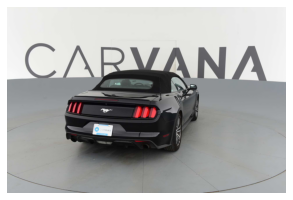

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [72]:
img.shape

torch.Size([3, 1280, 1918])

In [16]:
def get_mask_from_path(x): return Path(str(x.parent)+'_masks')/(x.name.split('.')[0]+'_mask.gif')

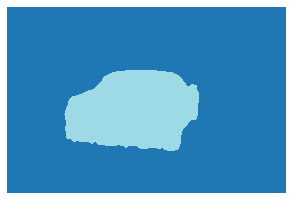

In [61]:
mask = open_mask(get_mask_from_path(img_f), div=True)
mask.show(figsize=(5,5), alpha=1)

In [62]:
mask.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [63]:
mask.data.unique()

tensor([0, 1])

So the masks are in `[0, 255]`. Probably want to transform the images to divide by 255.

## Make a validation set

Each car has exactly 16 images, each one taken at different angles. Each car has a unique id and images are named according to id_01.jpg, id_02.jpg ... id_16.jpg.

In [42]:
from random import shuffle

In [28]:
train_images = (path/'train').ls()

In [36]:
img_ids = set()
for img_path in train_images:
    img_id = str(img_path.name).split('_')[0]
    img_ids.add(img_id)

In [38]:
len(img_ids)

318

In [59]:
318*16 == len(train_images)

True

So there are 318 cars in total, and each car has 16 images

In [39]:
VAL_FRAC = 0.2

Randomly shuffle the car ids

In [47]:
img_ids = list(img_ids)
shuffle(img_ids)

Split the car IDs into a validation set

In [48]:
validation_ids = img_ids[:int(len(img_ids)*0.2)]
train_ids = img_ids[int(len(img_ids)*0.2):]

In [49]:
len(validation_ids) + len(train_ids)

318

Get all images associated with the validation set

In [52]:
validation_ids = set(validation_ids)

In [85]:
valid_names = []
for img_path in train_images:
    img_id = str(img_path.name).split('_')[0]
    if img_id in validation_ids:
        valid_names.append(img_path.name)

In [86]:
len(valid_names)

1008

## Build a databunch

In [76]:
get_mask_from_path(valid_names[0])

PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/11fcda0a9e1c_02_mask.gif')

In [22]:
bs = 8

In [66]:
codes = ['bg','car']

In [79]:
valid_names[0]

PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/11fcda0a9e1c_02.jpg')

In [102]:
doc(SegmentationLabelList)

See here: https://forums.fast.ai/t/unet-binary-segmentation/29833/48

In [116]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [117]:
src = (SegItemListCustom.from_folder(path/'train')
                           .split_by_files(valid_names)
                           .label_from_func(get_mask_from_path, classes=codes)
      )

In [124]:
# src = (SegmentationItemList.from_folder(path/'train')
#                            .split_by_files(valid_names)
#                            .label_from_func(get_mask_from_path, classes=codes)
#       )

# src = (SegmentationLabelList.from_folder(path/'train')
#                            .split_by_files(valid_names)
#                            .label_from_func(get_mask_from_path, classes=codes)
#       )

In [126]:
# data = src.databunch(bs=bs)

In [125]:
data = (src.transform(get_transforms(), tfm_y=True, size=224)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
       )

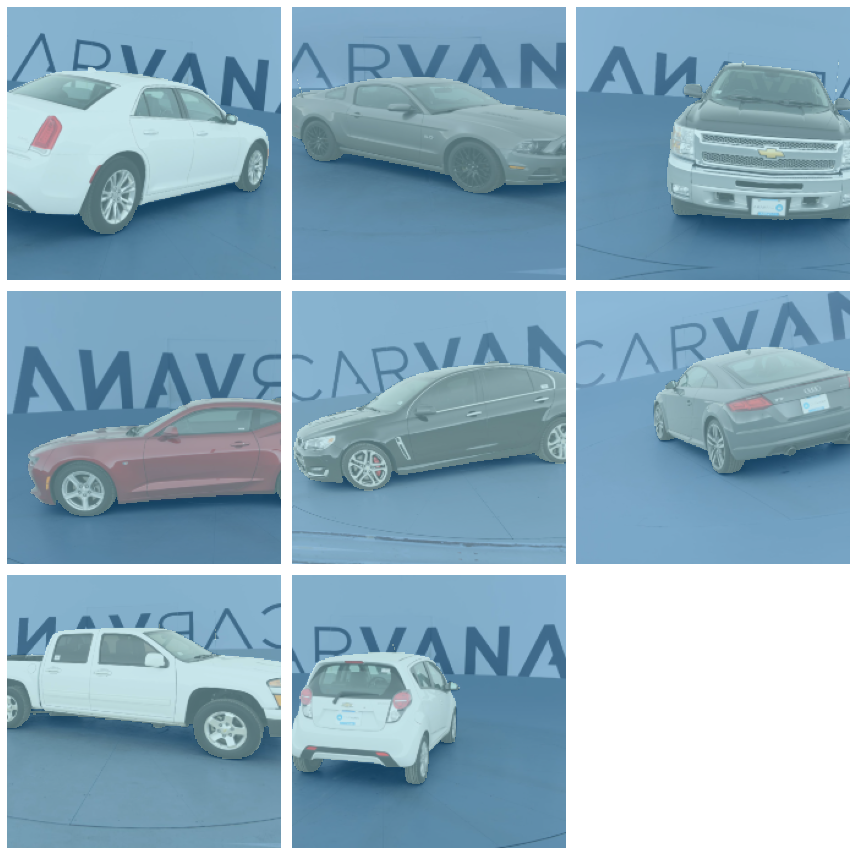

In [127]:
data.show_batch(3)